In [1]:
import re

# read four_difits.txt
with open('four_digits.txt') as f:
    data = f.read()

# regex four digits that are a whole word
regex_digits = re.compile(r'\b\d{4}\b')
matches = regex_digits.findall(data)
print(matches)

# regex of words that start with 'super'
# + at least one additional character
regex_super = re.compile(r'\bsuper\w+')
matches = regex_super.findall(data)
print(matches)

# regex extract wiki links
# keep only the text inside the brackets and the first part before a |
# the first part is the link
regex_wiki = re.compile(r'\[\[([^\|\]]+)(?:\|[^\]]+)?\]\]')
regex_wiki_2 = re.compile(r'\[\[(.*?)\]\]')
matches = regex_wiki.findall(data)
matches_2 = regex_wiki_2.findall(data)
print(matches_2)
print(matches)



['1234', '9999']
['superpolaroid', 'supertaxidermy', 'superbeer']
['drinking vinegar', 'gentrify', 'hashtag', 'Bicycle|Bicycle(two-wheeled type)', 'Pitchfork|Pitchfork Magazine']
['drinking vinegar', 'gentrify', 'hashtag', 'Bicycle', 'Pitchfork']


In [2]:
# Scrapping data from wikipedia

import urllib.request

# set base url
baseurl = "https://en.wikipedia.org/w/api.php?"
info = "titles=List_of_country_music_performers"
action = "action=query"
content = "prop=revisions&rvprop=content"
dataformat ="format=json"

# get the page
url = baseurl + info
query = "{}{}&{}&{}&{}".format(baseurl, action, content, info, dataformat)
print(url)
req = urllib.request.Request(query)
with urllib.request.urlopen(req) as response:
    page = response.read()
    wiki_text = page.decode('utf-8')

if wiki_text is not None:
    print('Page downloaded successfully')

# print(wiki_text)
# save the page in a file
with open('wiki_text.txt', 'w') as f:
    f.write(wiki_text)


https://en.wikipedia.org/w/api.php?titles=List_of_country_music_performers
Page downloaded successfully


In [3]:
# use the regex to extract the links
matches = regex_wiki.findall(wiki_text)
print(len(matches))
print(matches)

# filter remove all matches that contain a colon
filtered = [match for match in matches if ':' not in match]
print(len(filtered))
print(filtered)

# filter remove duplicates
filtered_2 = list(set(filtered))
print(len(filtered_2))
print(filtered_2)

# remove a speicify value in the set
value = 'country music'
if value in filtered_2:
    filtered_2.remove(value)

# encode the values to utf-8 and decode unicode_escape
reencoded = [value.encode('utf-8').decode('unicode_escape') for value in filtered_2]
print(reencoded)

# change the spaces to underscores
artist = [value.replace(' ', '_') for value in reencoded]
print(len(artist))



2163
['Special:ApiFeatureUsage', 'country music', '3 of Hearts (band)', '4 Runner', '8 Ball Aitken', 'File:Gene Autry.JPG', 'File:Eddie Arnold 1969.JPG', 'File:Roy Acuff 1950.JPG', 'File:Rodney Atkins pointing up.jpg', 'The Abrams Brothers', 'Ace in the Hole Band', 'Roy Acuff', 'Kay Adams (singer)', 'Ryan Adams', 'Doug Adkins', 'Trace Adkins', 'David \\"Stringbean\\" Akeman', 'Rhett Akins', 'Alabama (band)', 'Lauren Alaina', 'Jason Aldean', 'Alee (singer)', 'Daniele Alexander', 'Jessi Alexander', 'Gary Allan', 'Susie Allanson', 'Deborah Allen', 'Duane Allen', 'Harley Allen', 'Jimmie Allen', 'Rex Allen', 'Terry Allen (country singer)', 'Allman Brothers Band', 'Gregg Allman', 'Tommy Alverson', 'Dave Alvin', 'Amazing Rhythm Aces', 'American Young', 'Don Amero', 'Colin Amey', 'Al Anderson (NRBQ)', 'Bill Anderson (singer)', 'Brent Anderson (singer)', 'Coffey Anderson', 'John Anderson (singer)', 'Keith Anderson', 'Liz Anderson', 'Lynn Anderson', 'Sharon Anderson (singer)', 'Elisabeth Andreas

In [4]:
# DO NOT RUN AGAIN 13mins
# set base url for wikipedia API and the different parameters
baseurl = "https://en.wikipedia.org/w/api.php?"
action = "action=query"
content = "prop=revisions&rvprop=content"
dataformat ="format=json"

#  queries = []
for a in artist:
    t = f"titles={urllib.parse.quote(a)}"
    query = "{}{}&{}&{}&{}".format(baseurl, action, content, t, dataformat)
    # queries.append(query)

    wikiresponse = urllib.request.urlopen(query)
    wikidata = wikiresponse.read()
    wikitext = wikidata.decode('utf-8')

    if '/' in a:
        a = a.replace('/', '_')

    if '"' in a:
        a = a.replace('"', '')

    # save the page in a file in artist_data folder
    with open('artist_data/{}.txt'.format(a), 'w') as f:
        f.write(wikitext)

    # break

# print(queries[0])

In [4]:
# read all the files in the artist_data folder and replace file name if it contains a '"'
import os
files = os.listdir('artist_data')

print(len(files))

# for file in files:
#     if '"' in file:
#         new_file = file.replace('"', '')
#         os.rename('artist_data/{}'.format(file), 'artist_data/{}'.format(new_file))
#         print('File renamed: {}'.format(new_file))

2098


## Creating the network

In [5]:
def get_links(data: str):
    matches = regex_wiki.findall(data)

    # remove artist that contains semi-colon
    filtered = [match for match in matches if ':' not in match]

    # remove duplicates
    no_duplicates = list(set(filtered))

    if 'country music' in no_duplicates:
        no_duplicates.remove('country music')

    reencoded = [value.encode('utf-8').decode('unicode_escape') for value in no_duplicates]

    artists = [value.replace(' ', '_') for value in reencoded]
    artists = [value.replace('/', '_') for value in artists]
    artists = [value.replace('"', '') for value in artists]

    return artists

In [6]:
def count_words(text):
    # Use regex to match words, which are sequences of alphanumeric characters
    words = re.findall(r'\b\w+\b', text)
    return len(words)

In [7]:
import networkx as nx

# create the final nodes
# for each filename remove the .txt
nodes = [file.replace('.txt', '') for file in files]

# create a DiGraph
G = nx.DiGraph()

# add the nodes
G.add_nodes_from(nodes)

for file in files:
    node = file.replace('.txt', '')

    with open('artist_data/{}'.format(file)) as f:
        data = f.read()

    len_content = count_words(data)

    # save in the node the number of words
    G.nodes[node]['len_content'] = len_content

    links = get_links(data)

    for link in links:
        # print('Link: {}'.format(link))
        if link in nodes:
            G.add_edge(node, link)

    # print('File processed: {}'.format(file))
    # print(len(links))

    # if count == 10:
    #     break

# number of nodes
print(G.number_of_nodes())
# number of edges
print(G.number_of_edges())

2098
17691


In [9]:
# store the graph in a pickle file
import pickle

# store the graph
with open('artist_graph.pkl', 'wb') as f:
    pickle.dump(G, f)

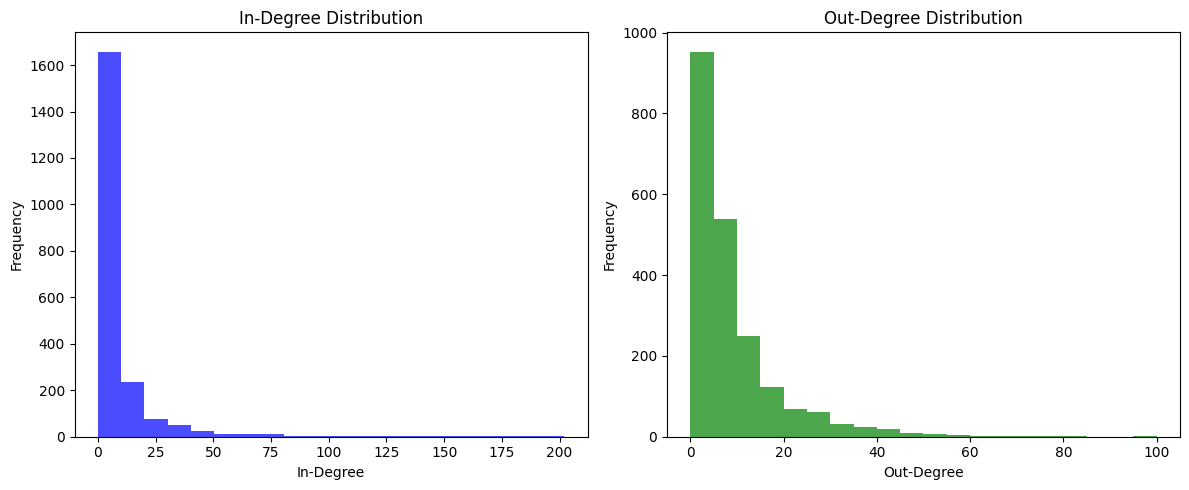

In [16]:
import matplotlib.pyplot as plt

def plot_degree_distributions(G):
    in_degrees = [G.in_degree(n) for n in G.nodes()]
    out_degrees = [G.out_degree(n) for n in G.nodes()]

    plt.figure(figsize=(12, 5))

    # Plot In-Degree Distribution
    plt.subplot(1, 2, 1)
    plt.hist(in_degrees, bins=20, color='blue', alpha=0.7)
    plt.title("In-Degree Distribution")
    plt.xlabel("In-Degree")
    plt.ylabel("Frequency")

    # Plot Out-Degree Distribution
    plt.subplot(1, 2, 2)
    plt.hist(out_degrees, bins=20, color='green', alpha=0.7)
    plt.title("Out-Degree Distribution")
    plt.xlabel("Out-Degree")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

# Call the function
plot_degree_distributions(G)


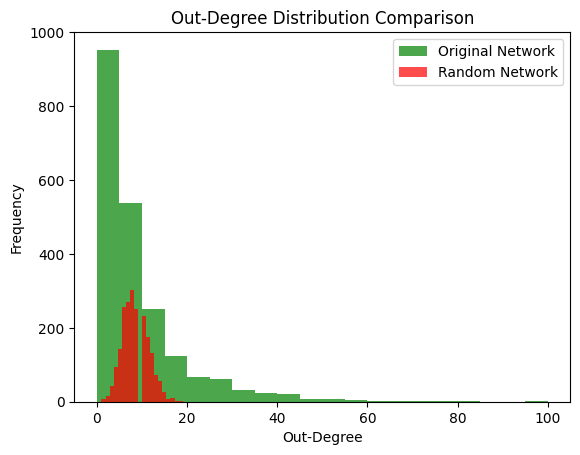

In [17]:
def compare_out_degree_to_random(G):
    N = G.number_of_nodes()
    E = G.number_of_edges()

    # Generate random network with the same number of nodes and edges
    random_graph = nx.gnm_random_graph(N, E, directed=True)
    random_out_degrees = [random_graph.out_degree(n) for n in random_graph.nodes()]
    
    original_out_degrees = [G.out_degree(n) for n in G.nodes()]

    plt.hist(original_out_degrees, bins=20, alpha=0.7, color='green', label="Original Network")
    plt.hist(random_out_degrees, bins=20, alpha=0.7, color='red', label="Random Network")
    plt.title("Out-Degree Distribution Comparison")
    plt.xlabel("Out-Degree")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

# Call the function
compare_out_degree_to_random(G)


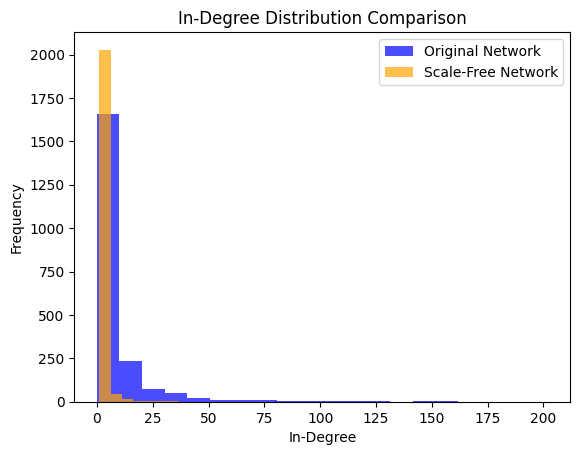

In [18]:
def compare_in_degree_to_scalefree(G):
    N = G.number_of_nodes()

    # Generate scale-free network
    scale_free_graph = nx.barabasi_albert_graph(N, 1)  # 'm' is the number of edges to attach from a new node to existing ones
    scale_free_graph = scale_free_graph.to_directed()  # Convert to directed graph

    scale_free_in_degrees = [scale_free_graph.in_degree(n) for n in scale_free_graph.nodes()]
    original_in_degrees = [G.in_degree(n) for n in G.nodes()]

    plt.hist(original_in_degrees, bins=20, alpha=0.7, color='blue', label="Original Network")
    plt.hist(scale_free_in_degrees, bins=20, alpha=0.7, color='orange', label="Scale-Free Network")
    plt.title("In-Degree Distribution Comparison")
    plt.xlabel("In-Degree")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

# Call the function
compare_in_degree_to_scalefree(G)


In [19]:
in_degrees = sorted(G.in_degree(), key=lambda x: x[1], reverse=True)[:5]
out_degrees = sorted(G.out_degree(), key=lambda x: x[1], reverse=True)[:5]

print("Top 5 Performers by In-Degree:")
for performer, in_deg in in_degrees:
    print(f"{performer}: {in_deg}")

print("\nTop 5 Performers by Out-Degree:")
for performer, out_deg in out_degrees:
    print(f"{performer}: {out_deg}")



Top 5 Performers by In-Degree:
Willie_Nelson: 202
Johnny_Cash: 184
Elvis_Presley: 177
Dolly_Parton: 162
George_Jones: 156

Top 5 Performers by Out-Degree:
Hillary_Lindsey: 100
Pam_Tillis: 82
Randy_Travis: 75
Vince_Gill: 71
Patty_Loveless: 68


In [23]:
pages_with_content = [(n, G.nodes[n]['len_content']) for n in G.nodes() if 'len_content' in G.nodes[n]]
top_10_longest = sorted(pages_with_content, key=lambda x: x[1], reverse=True)[:10]

print("Top 10 Pages with Longest Wiki Entries:")
for page, length in top_10_longest:
    print(f"{page}: {length} words")

Top 10 Pages with Longest Wiki Entries:
Beyoncé: 64599 words
Taylor_Swift: 56927 words
Miley_Cyrus: 51832 words
Justin_Bieber: 51252 words
Carrie_Underwood: 46003 words
Justin_Timberlake: 45283 words
Demi_Lovato: 44703 words
Bob_Dylan: 41834 words
Ed_Sheeran: 36912 words
Elvis_Presley: 34593 words


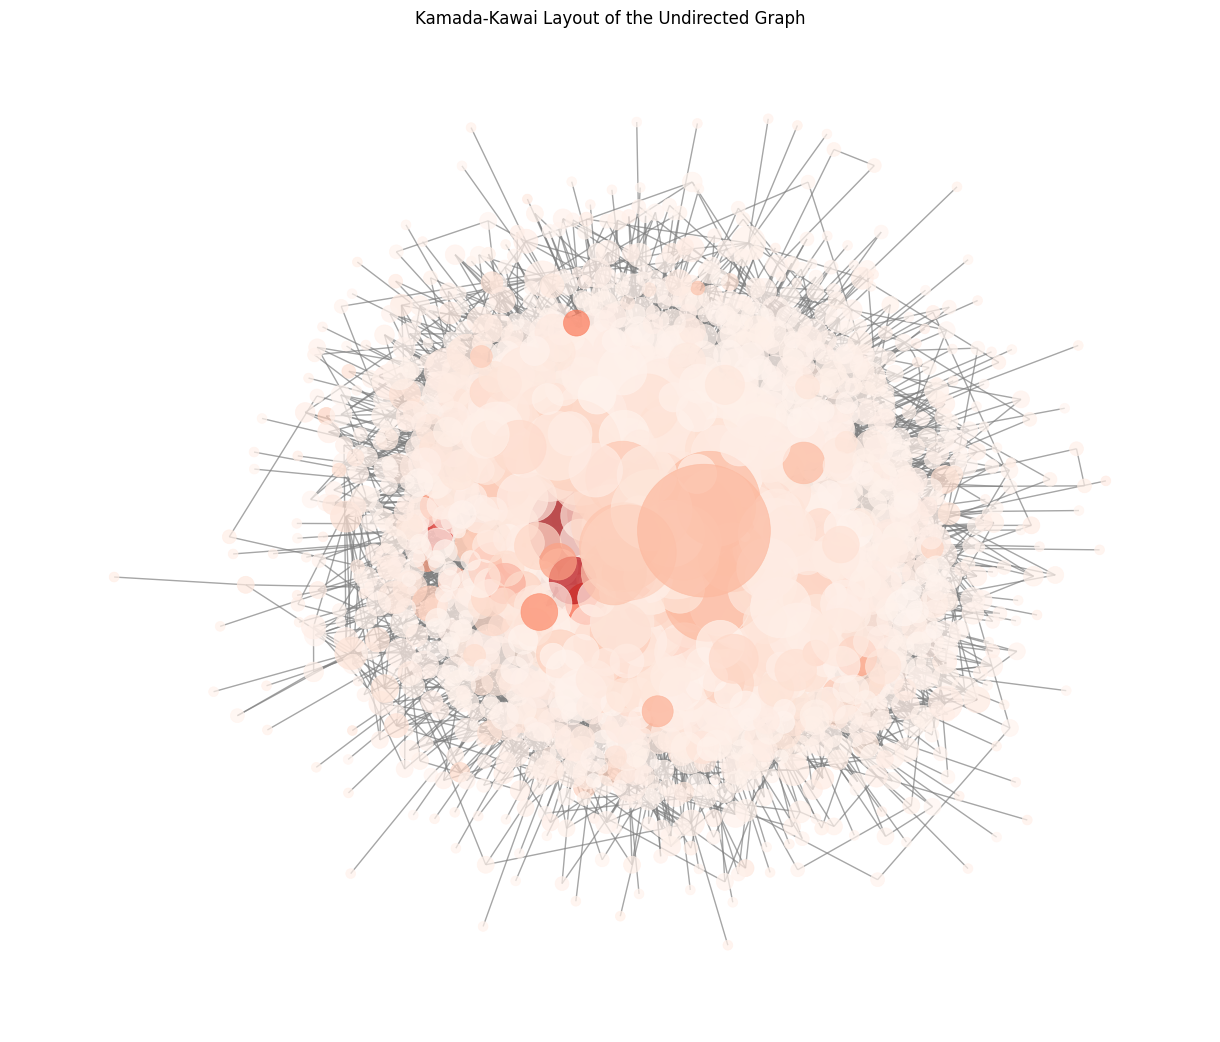

In [29]:
G_undir = G.to_undirected()

# plot the network
degrees = dict(G_undir.degree())

# Normalize node sizes based on degree (you can tweak scaling factor if necessary)
node_sizes = [degrees[node] * 50 for node in G_undir.nodes()]

# Get 'length_of_content' attribute for each node, if it exists
content_lengths = [G.nodes[node].get('len_content', 0) for node in G_undir.nodes()]

# Normalize content lengths for color mapping
norm = plt.Normalize(vmin=min(content_lengths), vmax=max(content_lengths))
cmap = plt.get_cmap('Reds')  # Choosing a simple sequential colormap

# Draw the network using Kamada-Kawai layout
plt.figure(figsize=(12, 10), facecolor='black')
pos = nx.kamada_kawai_layout(G_undir)

# Draw the graph with customized node sizes and colors
nx.draw(
    G_undir, 
    pos, 
    with_labels=False,  # Remove labels for clarity
    node_size=node_sizes,  # Size of nodes based on degree
    node_color=content_lengths,  # Color based on 'length_of_content' attribute
    cmap=cmap,  # Colormap for node colors
    edge_color='gray',  # Color of edges
    alpha=0.7,  # Transparency of edges
    linewidths=0.5  # Width of edges
)

# Add a color bar to indicate content length scale
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array(content_lengths)
# cbar = plt.colorbar(sm)
# cbar.set_label('Length of Content')


plt.title("Kamada-Kawai Layout of the Undirected Graph")
plt.gca().set_facecolor('black')  # Set axis background to black
plt.tick_params(colors='white')  # White tick labels
plt.show()
